
###### Lab 4 - RNN
<br>
umu-id: anth2786<br>
<br>
The first part (the data gathering), the code is equivalent to the code in the tutorial at:<br>
&nbsp;&nbsp;&nbsp;    https://www.tensorflow.org/tutorials/structured_data/time_series <br>
It runs from Setup to "The lab". The code from that tutorial is under Apache 2.0 licensing. More info on the licensing is in the end of this notebook.
<br><br>

For the lab part, part of the code is based on the same tutorial, but adapted. Others are based on code from the previous labs:<br>
&nbsp;&nbsp;&nbsp;    https://github.com/dmfow/dl1<br>
&nbsp;&nbsp;&nbsp;    https://github.com/dmfow/dl2<br>
&nbsp;&nbsp;&nbsp;    https://github.com/dmfow/dl3<br><br>
and from the webpage:<br>
&nbsp;&nbsp;&nbsp;    https://keras.io/api/layers/recurrent_layers/lstm/<br>
&nbsp;&nbsp;&nbsp;    https://keras.io/api/layers/recurrent_layers/gru/<br>

<br>
<br>

In [2]:
import os

# Disable running on GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Setup

In [3]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [5]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [6]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

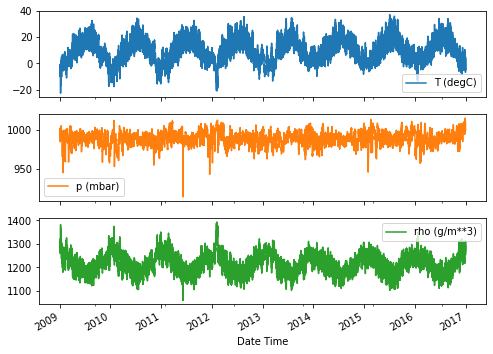

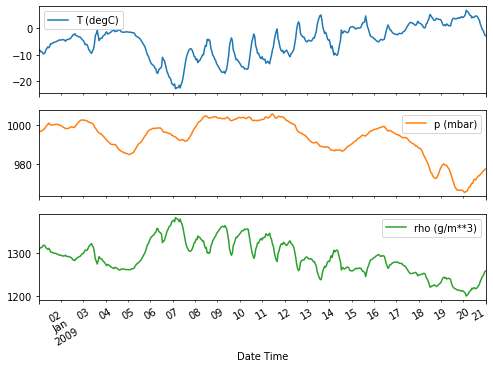

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

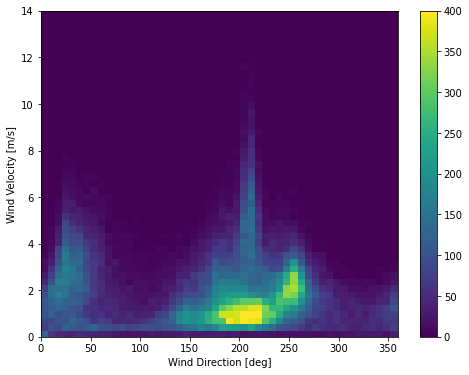

In [10]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [11]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

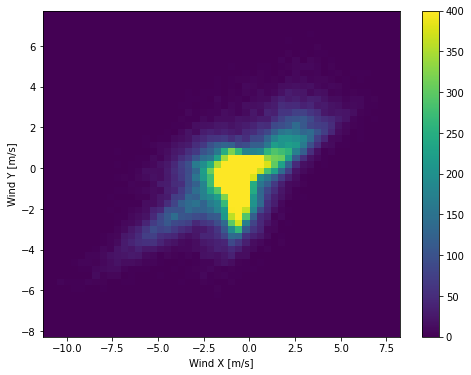

In [12]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [13]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [14]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

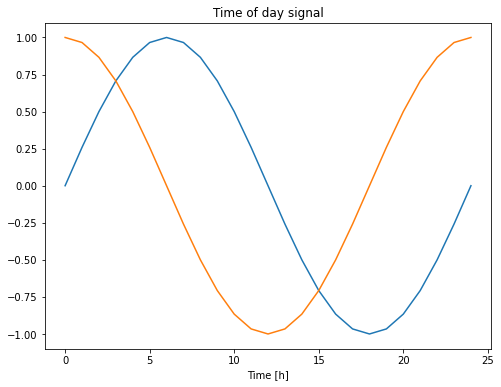

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

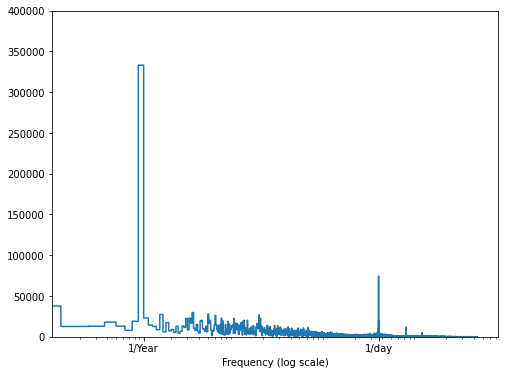

In [16]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [17]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [18]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

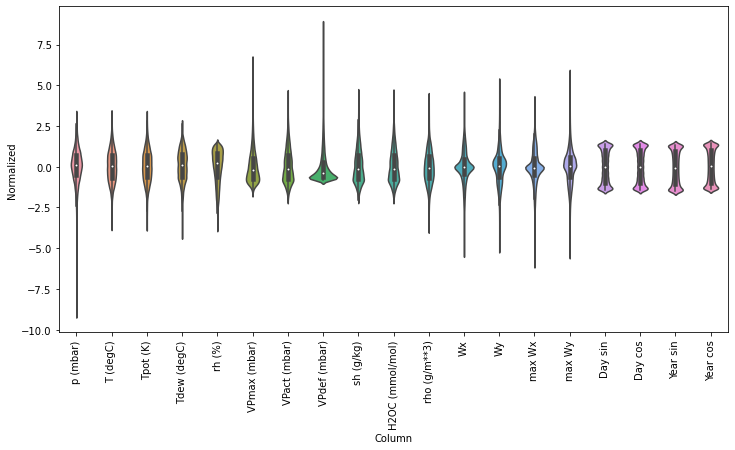

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [20]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [21]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [22]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [23]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [24]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [25]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

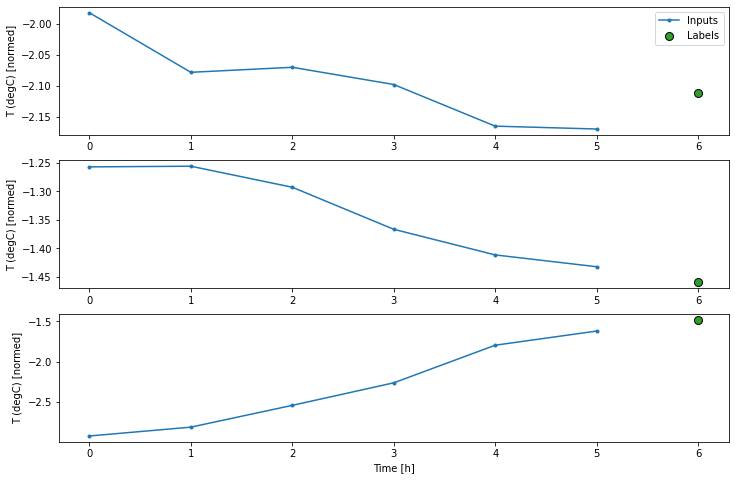

In [27]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

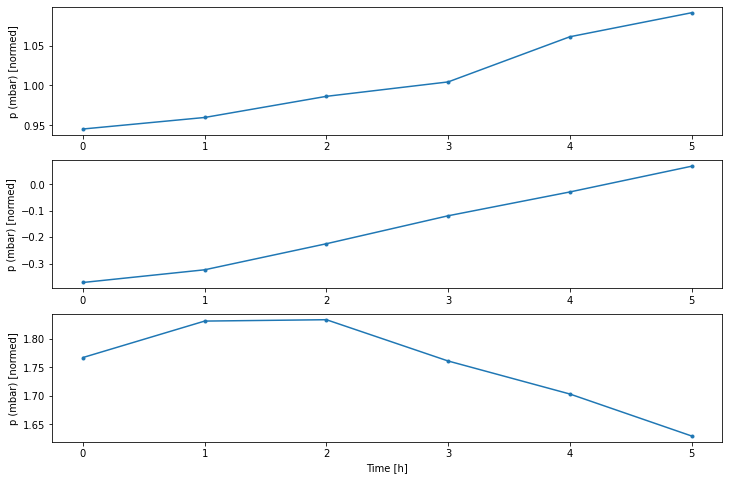

In [28]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [29]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [30]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [31]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [32]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


# ----------------------- The LAB -------------------

## A: Analysis on MSE, MSA
Analysis on MSE, MSA question; Why does the tutorial choose to mix: (loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()]) ?

Losses are used to train a model. When training a model you want to take all values in consideration, and MSE (MeanSquaredError), which is a square root, penalizes errors more the bigger the error is.
Eg MSE is better to use as a loss function if being off by 20 is worse than being off by 5. This is relevant in forcasting the weather.

Metrics (or accuracy) on the other hand should use a function that is easily understood, and there MAE (MeanAbsoluteError) outperform MSE as MAE describe (absolute) average error and not a squared figure.

Considering MSE vs RMSE (Root MeanSquaredError), one reason to use MSE could be that MSE is faster to compute, even though it is possible that RMSE is better to use in forcasting as it reflects to the original scale better.

## B. Improved LSTM

<b>Performance to beat (values from the tutorial):</b> <br>
Baseline    : 0.0852 <br>
Linear      : 0.0670 <br>
Dense       : 0.0622 <br>
Multi step dense: 0.0595 <br>
Conv        : 0.0618 <br>
LSTM        : 0.0530 <br>

In [33]:
# Nicely formatted time string
import time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [34]:
import time
from tensorflow.keras.models import Sequential
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow.keras
import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [35]:

val_performance = {}
performance = {}

In [36]:
# Make forcast window with 24 (input_width + label_width) values to base the one step (shift) forward predicion on.
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

###### Make some models with different hyperparameters and evaluate it

We will try:<br>
&nbsp;&nbsp;&nbsp;    Different number of layers<br>
&nbsp;&nbsp;&nbsp;    Layer normalization<br>
&nbsp;&nbsp;&nbsp;    Different neurons/units<br>
&nbsp;&nbsp;&nbsp;    Different Activations<br>
&nbsp;&nbsp;&nbsp;    Dropouts on the inputs<br>
&nbsp;&nbsp;&nbsp;    Dropouts on the linear transformation on the recurrent state (recurrent_dropout)

In [37]:
# Model 1:
# BASE MODEL - Equivalent to the tutorial

units = 32

model1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [38]:
# Model 2 - Change Unit size

units = 16

model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [39]:
# Model 3, change activation activation = sigmoid (above tanh), recurrent = tanh (above sigmoid)

units = 32

model3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, 
                activation="sigmoid",
                recurrent_activation="tanh",
                return_sequences=True),
    
   
    tf.keras.layers.Dense(units=1)
])

In [40]:
# Model 4 - Normalize the layer (the activation/recurrent are written in the code, but are the defaults as in the
# model 1 and model 2)

units = 32

model4 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LSTM(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),    
    tf.keras.layers.Dense(units=1)
])

In [41]:
# Model 5 - 2 LSTM layers with normalization

units = 32

model5 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LSTM(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),
    
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LSTM(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),
    
    tf.keras.layers.Dense(units=1)
])

In [42]:
# Model 6 - "In-layer" LSTM dropout on input and dropout on recurrent state on both layers 

units = 32
dropout1 = 0.25
dropout2 = 0.25

model6 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LSTM(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout1,
                recurrent_dropout=dropout2,
                return_sequences=True),
    
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.LSTM(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout1,
                recurrent_dropout=dropout2,
                return_sequences=True),
    
    tf.keras.layers.Dense(units=1)
])

In [43]:
print('model 1')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model1(wide_window.example[0]).shape)

print('')
print('model 2')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model2(wide_window.example[0]).shape)

print('')
print('model 3')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model3(wide_window.example[0]).shape)

print('')
print('model 4')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model4(wide_window.example[0]).shape)

print('')
print('model 5')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model5(wide_window.example[0]).shape)

print('')
print('model 6')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', model6(wide_window.example[0]).shape)

model 1
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 2
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 3
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 4
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 5
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 6
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [44]:
# Compile and then do a fit of one model. This is taken from the tutorial as it is part of the data handling
# It is easier to have it in the same method as we are using the tutorial window function to make the 
# training and validation data

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                        verbose=2,
                      callbacks=[early_stopping])
  return history

In [45]:
# run/train the 6 models
start_time = time.time()

history1 = compile_and_fit(model1, wide_window)

print("model 1 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

history2 = compile_and_fit(model2, wide_window)

print("model 2 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


history3 = compile_and_fit(model3, wide_window)

print("model 3 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


history4 = compile_and_fit(model4, wide_window)

print("model 4 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))



history5 = compile_and_fit(model5, wide_window)

print("model 5 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


history6 = compile_and_fit(model6, wide_window)

print("model 6 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

print("-------------------- ALL DONE -----------------------")



Epoch 1/20
1533/1533 - 9s - loss: 0.0343 - mean_absolute_error: 0.1014 - val_loss: 0.0069 - val_mean_absolute_error: 0.0589
Epoch 2/20
1533/1533 - 8s - loss: 0.0065 - mean_absolute_error: 0.0565 - val_loss: 0.0061 - val_mean_absolute_error: 0.0542
Epoch 3/20
1533/1533 - 8s - loss: 0.0060 - mean_absolute_error: 0.0538 - val_loss: 0.0058 - val_mean_absolute_error: 0.0522
Epoch 4/20
1533/1533 - 8s - loss: 0.0058 - mean_absolute_error: 0.0526 - val_loss: 0.0057 - val_mean_absolute_error: 0.0519
Epoch 5/20
1533/1533 - 8s - loss: 0.0057 - mean_absolute_error: 0.0520 - val_loss: 0.0056 - val_mean_absolute_error: 0.0514
Epoch 6/20
1533/1533 - 8s - loss: 0.0056 - mean_absolute_error: 0.0514 - val_loss: 0.0056 - val_mean_absolute_error: 0.0517
Epoch 7/20
1533/1533 - 8s - loss: 0.0055 - mean_absolute_error: 0.0511 - val_loss: 0.0056 - val_mean_absolute_error: 0.0509
Epoch 8/20
1533/1533 - 8s - loss: 0.0054 - mean_absolute_error: 0.0507 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 9/

Elapsed time: 0:18:44.24
-------------------- ALL DONE -----------------------


###### Evaluate

In [46]:
# Evaluate the models on test data and validation data, and save the evaluation results of the 6 models

start_time = time.time()

IPython.display.clear_output()
val_performance['LSTM'] = model1.evaluate(wide_window.val)
performance['LSTM'] = model1.evaluate(wide_window.test, verbose=0)

val_performance['LSTM model 2'] = model2.evaluate(wide_window.val)
performance['LSTM model 2'] = model2.evaluate(wide_window.test, verbose=0)

val_performance['LSTM model 3'] = model3.evaluate(wide_window.val)
performance['LSTM model 3'] = model3.evaluate(wide_window.test, verbose=0)

val_performance['LSTM model 4'] = model4.evaluate(wide_window.val)
performance['LSTM model 4'] = model4.evaluate(wide_window.test, verbose=0)

val_performance['LSTM model 5'] = model5.evaluate(wide_window.val)
performance['LSTM model 5'] = model5.evaluate(wide_window.test, verbose=0)

val_performance['LSTM model 6'] = model6.evaluate(wide_window.val)
performance['LSTM model 6'] = model6.evaluate(wide_window.test, verbose=0)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

438/438 [==============================] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.059 - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.055 - ETA: 2s - loss: 0.0062 - mean_absolute_error: 0.055 - ETA: 1s - loss: 0.0062 - mean_absolute_error: 0.055 - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.055 - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.054 - ETA: 1s - loss: 0.0060 - mean_absolute_

438/438 [==============================] - ETA: 0s - loss: 0.0099 - mean_absolute_error: 0.075 - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.076 - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.076 - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.077 - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.077 - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0112 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.079 - ETA: 1s - loss: 0.0113 - mean_absolute_error: 0.078 - ETA: 1s - loss: 0.0113 - mean_absolute_

###### Plot the 24+1 datapoints and the respective predicted values

LSTM Model (1)


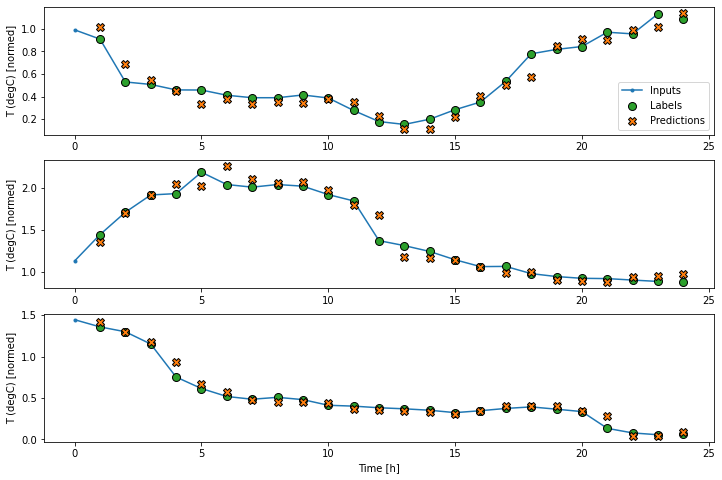

In [47]:
print('LSTM Model (1)')
wide_window.plot(model1)

Model 2


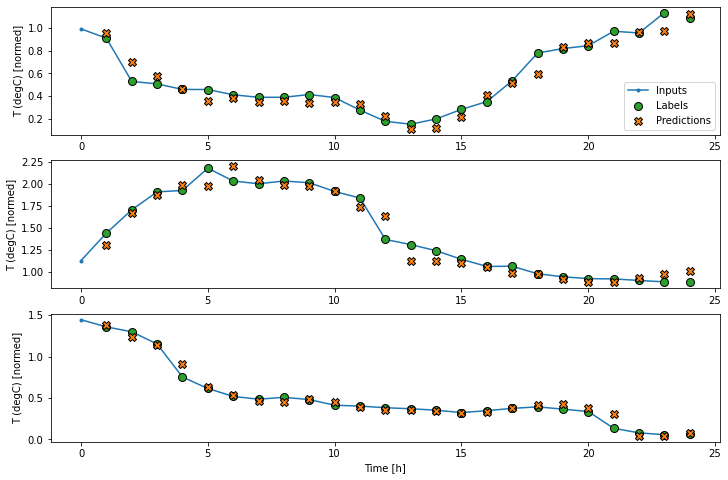

In [48]:
print('Model 2')
wide_window.plot(model2)

Model 3


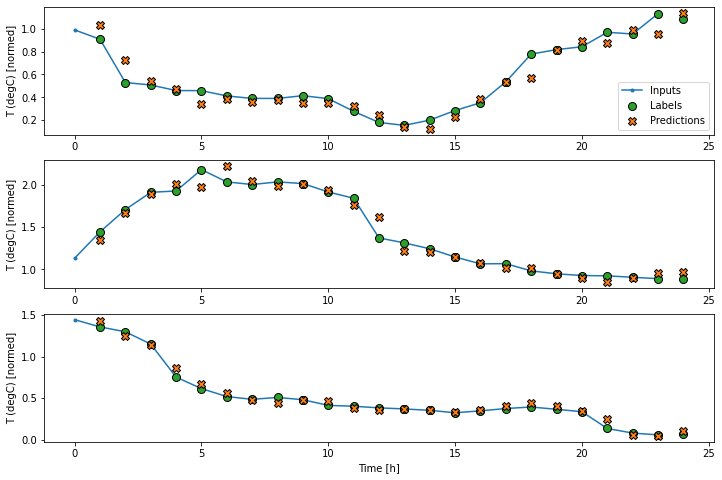

In [49]:
print('Model 3')
wide_window.plot(model3)

Model 4


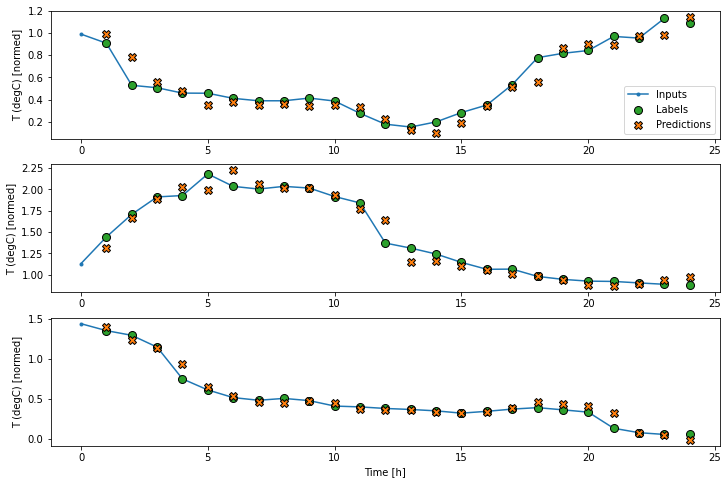

In [50]:
print('Model 4')
wide_window.plot(model4)


Model 5


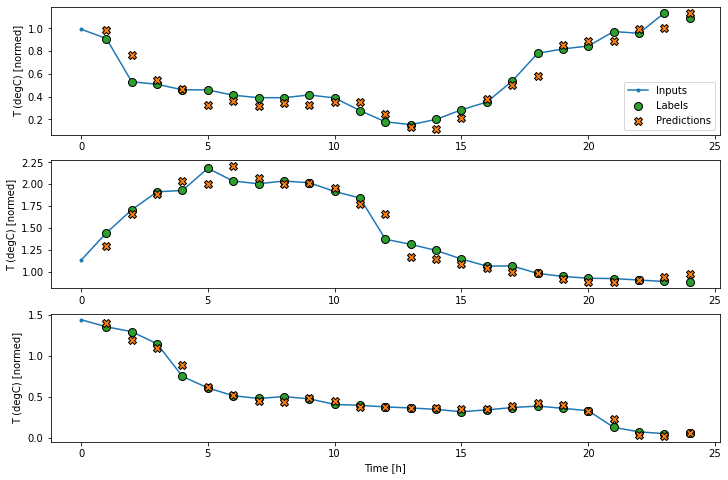

In [51]:
print('Model 5')
wide_window.plot(model5)

Model 6


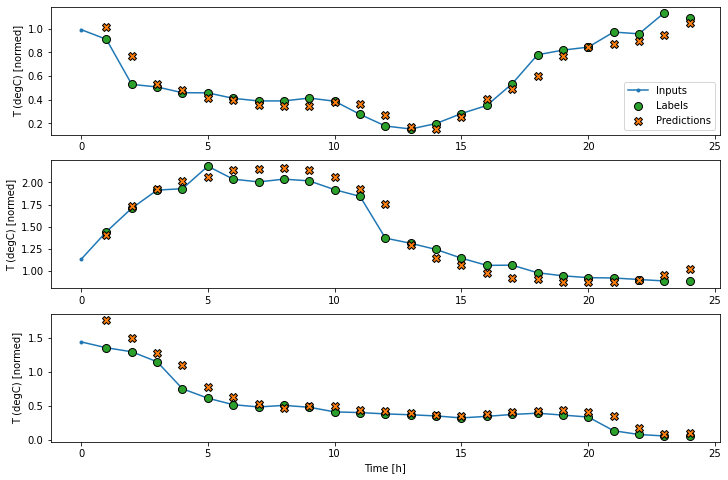

In [52]:
print('Model 6')
wide_window.plot(model6)

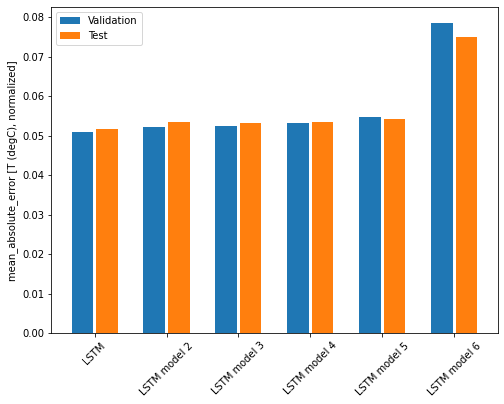

In [53]:
# Visualize the validation- and testdata MAE values of the different models

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = model1.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

##### Print performance of different models

In [54]:
# Print the MAE (MeanAbsoluteError) values for test data

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750


#### Analysis

Adding an in-layer dropout significanly worsen the performance of the predictions. (model 6)<br><br>
An extra LSTM layer does not improve the performance, but on the contrary worsen the performance slightly (model 5)<br>
<br>
The performance on the test data is slighlty worse than on the validation data except in model 5, where it is more or less the same. Model 5 have 2 LSTM layers. In another run (not given in this results), model 4 also had slightly better test data than validation data. Model 4 have a normalized LSTM layer.<br>
<br>
Using inversed Activation and recurrent_Activation functions compared to the defaults, gives slightly worse performance than using the defaults. (model 3). The same with model2 that is the same as model 1 but with 16 neurons/units instead of 32.<br>
In another run (not given in this results) the performance when using 16 or 32 neurons/units in the LSTM layer gives more or less the same performance. (model 2 and 1 respectively)<br>
 <br>
All models except the one with in-layer dropouts gives fairly the same result in predictions. Using default values with  32 neurons/units perform best on the weather data. When the degrees changes fast all models (except 6) have problems to do predictions, and when the weather changes slowly, all models(except 6) perform rather well. Model 4 (using 1 layer with normalization) are pretty spot on when the temperature changes slowly, looking at the graphs. <br>
 <br>
Changing the hyperparameters did not outperform the tutorial model (model 1).<br>
<br>
Model 1 was also the faster model to run. 6% faster than model 2, which was 15 % faster than model 3.
In a run earlier (not given in this results), Model 3 (changing the activation functions) was the fastest model (7% faster than model 1). So in a real time environment, model 3 and 1 should be compared more in regards to performance and execution time, to see which would be the preferred model.

## C. 3 models to predict 24 hours forward

Model 1 - Direct prediction (the 24th value forward)<br>
Model 2 - One-shot prediction of all 24 values forward at once<br>
Model 3 - One time predictions 24 times (All 24 values forward)<br>

###### C. Model 1
We will use Model 2 from part B, and adjust for prediction 24 hours forward

In [64]:
# Here we shift 24 hours ahead (instead of 1: shift = 24)

tewntyfour_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=24,
    label_columns=['T (degC)'])
tewntyfour_step_window

Total window size: 25
Input indices: [0]
Label indices: [24]
Label column name(s): ['T (degC)']

In [65]:
for example_inputs, example_labels in tewntyfour_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [66]:
units = 32

modelC1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [67]:
print('')
print('model C1')

print('Input shape:', tewntyfour_step_window.example[0].shape)
print('Output shape:', modelC1(tewntyfour_step_window.example[0]).shape)



model C1
Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [68]:
# compile and then do a fit of one model. It is easier to have it in the same method as we are using 
# the window function to make the training and validation data

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                        verbose=2,
                      callbacks=[early_stopping])
  return history

In [69]:
start_time = time.time()

historyC1 = compile_and_fit(modelC1, tewntyfour_step_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/20
1533/1533 - 3s - loss: 0.1366 - mean_absolute_error: 0.2806 - val_loss: 0.1243 - val_mean_absolute_error: 0.2758
Epoch 2/20
1533/1533 - 2s - loss: 0.1148 - mean_absolute_error: 0.2639 - val_loss: 0.1233 - val_mean_absolute_error: 0.2747
Epoch 3/20
1533/1533 - 2s - loss: 0.1137 - mean_absolute_error: 0.2626 - val_loss: 0.1218 - val_mean_absolute_error: 0.2729
Epoch 4/20
1533/1533 - 2s - loss: 0.1124 - mean_absolute_error: 0.2613 - val_loss: 0.1210 - val_mean_absolute_error: 0.2721
Epoch 5/20
1533/1533 - 2s - loss: 0.1118 - mean_absolute_error: 0.2603 - val_loss: 0.1203 - val_mean_absolute_error: 0.2712
Epoch 6/20
1533/1533 - 2s - loss: 0.1111 - mean_absolute_error: 0.2596 - val_loss: 0.1221 - val_mean_absolute_error: 0.2732
Epoch 7/20
1533/1533 - 2s - loss: 0.1105 - mean_absolute_error: 0.2589 - val_loss: 0.1194 - val_mean_absolute_error: 0.2703
Epoch 8/20
1533/1533 - 2s - loss: 0.1101 - mean_absolute_error: 0.2582 - val_loss: 0.1218 - val_mean_absolute_error: 0.2731
Epoch 9/

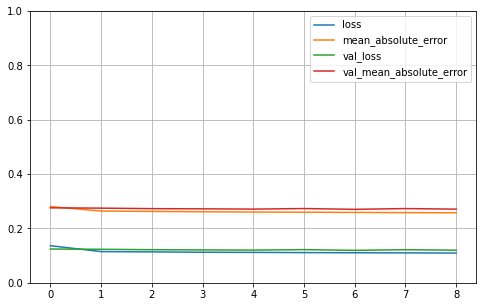

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(historyC1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [71]:
IPython.display.clear_output()
val_performance['24 step'] = modelC1.evaluate(tewntyfour_step_window.val)
performance['24 step'] = modelC1.evaluate(tewntyfour_step_window.test, verbose=0)

438/438 [==============================] - ETA: 0s - loss: 0.1571 - mean_absolute_error: 0.325 - ETA: 0s - loss: 0.1205 - mean_absolute_error: 0.273 - ETA: 0s - loss: 0.1207 - mean_absolute_error: 0.271 - ETA: 0s - loss: 0.1221 - mean_absolute_error: 0.272 - ETA: 0s - loss: 0.1208 - mean_absolute_error: 0.271 - ETA: 0s - loss: 0.1224 - mean_absolute_error: 0.273 - ETA: 0s - loss: 0.1225 - mean_absolute_error: 0.273 - ETA: 0s - loss: 0.1217 - mean_absolute_error: 0.272 - ETA: 0s - loss: 0.1208 - mean_absolute_error: 0.271 - ETA: 0s - loss: 0.1201 - mean_absolute_error: 0.271 - 0s 1ms/step - loss: 0.1200 - mean_absolute_error: 0.2710


24 step


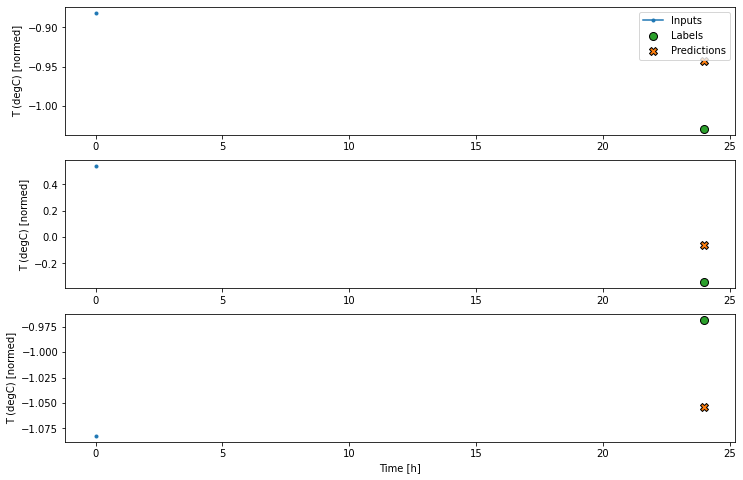

In [72]:
print('24 step')
tewntyfour_step_window.plot(modelC1)

In [73]:
for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750
24 step : 0.2398


###### Comment: 
The MAE is much higher in the model where predictions are done 24 steps forward, than the models where predictions 1 step forwards. So it is more difficult to do the predictions further away in the future. Let's now see how this compares to 2 other models predicting 24 steps forward

#### C. Model 2 - One-shot LSTM

This model is based on the tutorial

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

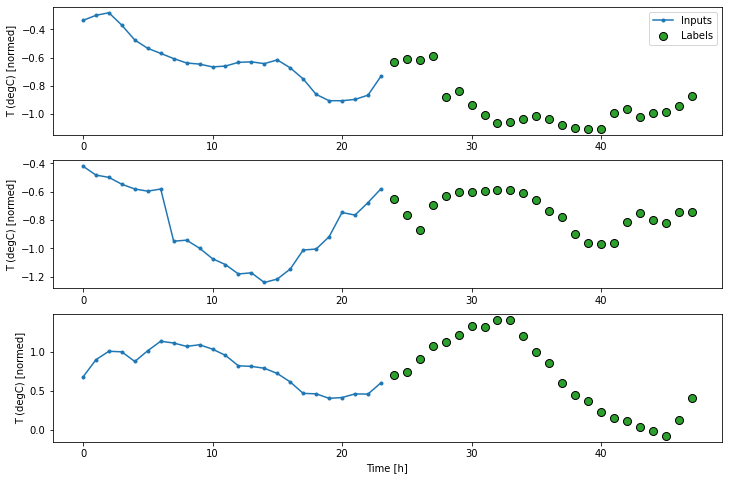

In [74]:
# Make a new window and plot the data for the window

OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [75]:
# Train the model

start_time = time.time()

modelC2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

historyC2 = compile_and_fit(modelC2, multi_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/20
1532/1532 - 9s - loss: 0.2894 - mean_absolute_error: 0.3610 - val_loss: 0.2314 - val_mean_absolute_error: 0.3076
Epoch 2/20
1532/1532 - 8s - loss: 0.2179 - mean_absolute_error: 0.2950 - val_loss: 0.2207 - val_mean_absolute_error: 0.2942
Epoch 3/20
1532/1532 - 8s - loss: 0.2098 - mean_absolute_error: 0.2857 - val_loss: 0.2181 - val_mean_absolute_error: 0.2900
Epoch 4/20
1532/1532 - 8s - loss: 0.2055 - mean_absolute_error: 0.2811 - val_loss: 0.2155 - val_mean_absolute_error: 0.2879
Epoch 5/20
1532/1532 - 8s - loss: 0.2023 - mean_absolute_error: 0.2782 - val_loss: 0.2142 - val_mean_absolute_error: 0.2864
Epoch 6/20
1532/1532 - 8s - loss: 0.2001 - mean_absolute_error: 0.2763 - val_loss: 0.2140 - val_mean_absolute_error: 0.2854
Epoch 7/20
1532/1532 - 8s - loss: 0.1983 - mean_absolute_error: 0.2749 - val_loss: 0.2136 - val_mean_absolute_error: 0.2850
Epoch 8/20
1532/1532 - 8s - loss: 0.1967 - mean_absolute_error: 0.2737 - val_loss: 0.2123 - val_mean_absolute_error: 0.2841
Epoch 9/

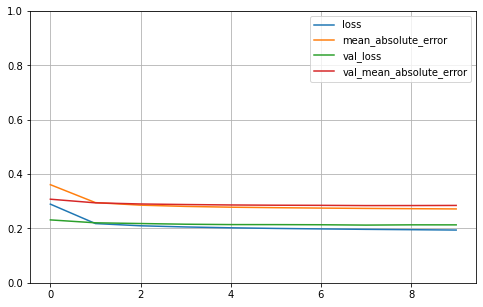

In [76]:
# Plot traning data

import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(historyC2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

437/437 [==============================] - ETA: 0s - loss: 0.1790 - mean_absolute_error: 0.259 - ETA: 0s - loss: 0.2044 - mean_absolute_error: 0.277 - ETA: 0s - loss: 0.2071 - mean_absolute_error: 0.281 - ETA: 0s - loss: 0.2101 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2117 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2112 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2105 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2115 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2117 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2121 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2133 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2126 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.284 - 1s 2ms/step - loss: 0.2132 - mean_absol

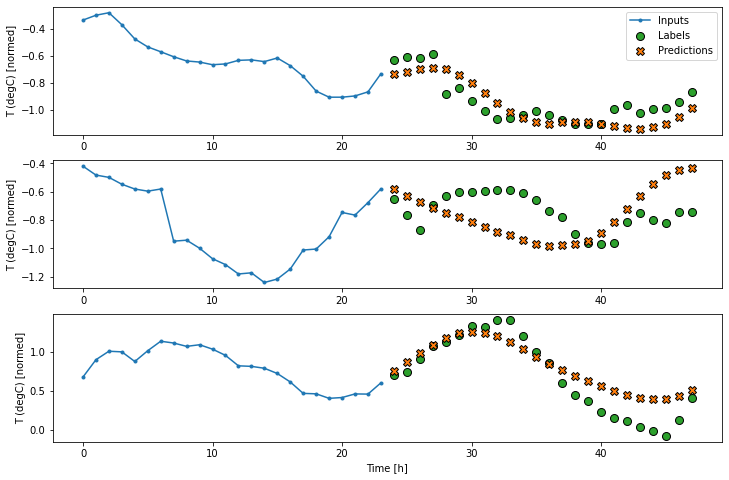

In [77]:
# Evaluate and Plot the predictions

IPython.display.clear_output()

val_performance['Single-shot-24pred'] = modelC2.evaluate(multi_window.val)
performance['Single-shot-24pred'] = modelC2.evaluate(multi_window.test, verbose=0)
multi_window.plot(modelC2)


Run the next model directly and make the analysis after that

#### C. MODEL 3 - Autoregressive - Predict all 24 forward hours in one step

This model is based on the tutorial's autoregressive model

In [113]:
OUT_STEPS = 24
units = 32

In [114]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


In [115]:
modelC3 = FeedBack(units=units, out_steps=OUT_STEPS)

In [116]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


In [117]:
prediction, state = modelC3.warmup(multi_window.example[0])
prediction.shape


TensorShape([32, 19])

In [118]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call


In [119]:
print('Output shape (batch, time, features): ', modelC3(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


In [120]:
start_time = time.time()

historyC3 = compile_and_fit(modelC3, multi_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/20
1532/1532 - 13s - loss: 0.3226 - mean_absolute_error: 0.3920 - val_loss: 0.2502 - val_mean_absolute_error: 0.3322
Epoch 2/20
1532/1532 - 12s - loss: 0.2324 - mean_absolute_error: 0.3148 - val_loss: 0.2372 - val_mean_absolute_error: 0.3192
Epoch 3/20
1532/1532 - 12s - loss: 0.2233 - mean_absolute_error: 0.3040 - val_loss: 0.2298 - val_mean_absolute_error: 0.3080
Epoch 4/20
1532/1532 - 12s - loss: 0.2185 - mean_absolute_error: 0.2985 - val_loss: 0.2254 - val_mean_absolute_error: 0.3031
Epoch 5/20
1532/1532 - 12s - loss: 0.2146 - mean_absolute_error: 0.2947 - val_loss: 0.2295 - val_mean_absolute_error: 0.3061
Epoch 6/20
1532/1532 - 12s - loss: 0.2121 - mean_absolute_error: 0.2921 - val_loss: 0.2251 - val_mean_absolute_error: 0.2998
Epoch 7/20
1532/1532 - 12s - loss: 0.2100 - mean_absolute_error: 0.2900 - val_loss: 0.2246 - val_mean_absolute_error: 0.3013
Epoch 8/20
1532/1532 - 12s - loss: 0.2075 - mean_absolute_error: 0.2881 - val_loss: 0.2253 - val_mean_absolute_error: 0.3013


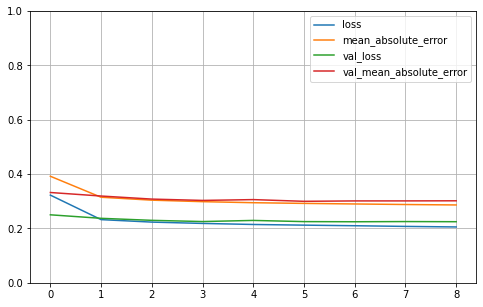

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(historyC3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

437/437 [==============================] - ETA: 0s - loss: 0.2072 - mean_absolute_error: 0.288 - ETA: 1s - loss: 0.2233 - mean_absolute_error: 0.299 - ETA: 1s - loss: 0.2249 - mean_absolute_error: 0.301 - ETA: 1s - loss: 0.2205 - mean_absolute_error: 0.298 - ETA: 1s - loss: 0.2216 - mean_absolute_error: 0.299 - ETA: 1s - loss: 0.2227 - mean_absolute_error: 0.300 - ETA: 1s - loss: 0.2235 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2225 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2233 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2237 - mean_absolute_error: 0.301 - ETA: 0s - loss: 0.2222 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2221 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2231 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2231 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2240 - mean_absolute_error: 0.301 - ETA: 0s - loss: 0.2240 - mean_absolute_error: 0.301 - ETA: 0s - loss: 0.2239 - mean_absolute_error: 0.300 - ETA: 0s - loss: 0.2244 - mean_absolute_

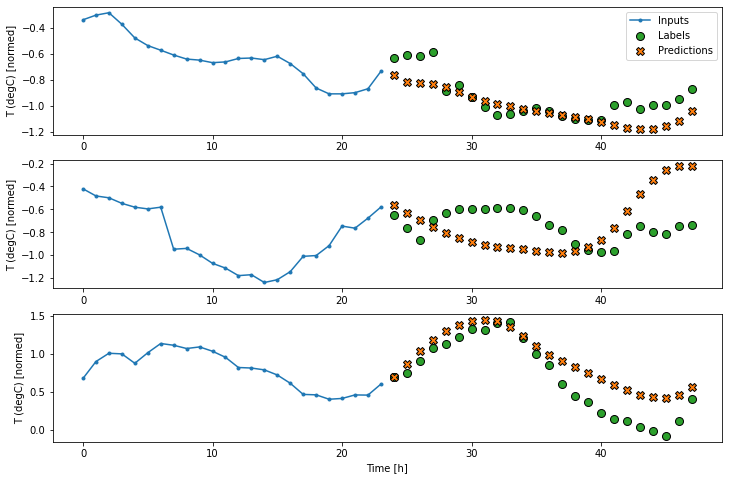

In [122]:
IPython.display.clear_output()

val_performance['AR LSTM'] = modelC3.evaluate(multi_window.val)
performance['AR LSTM'] = modelC3.evaluate(multi_window.test, verbose=0)
multi_window.plot(modelC3)

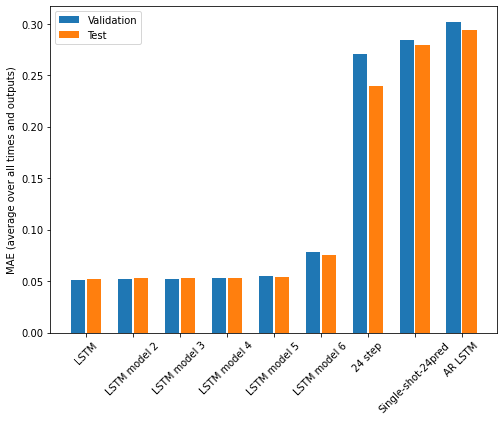

In [123]:
x = np.arange(len(performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = model1.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [124]:
# Print the performances

for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

LSTM    : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750
24 step : 0.2398
Single-shot-24pred: 0.2795
AR LSTM : 0.2937


###### Analysis

As stated above, the performance of predicting values further into the future is much worse than predicting the next step. Here we can see that the MAE is increasing 5 fold from aound 0,05 to 0,24-0,30. 
<br><br>
Comaring the tre 24 steps forward models, the first model have a better performace (lower MAE value). However this model only predict one value in the future. 
<br><br>
Predicting all future 24 forward steps in one shot, compared to doing it one by one using the last prediction as new input value (autoregressive), gives the one-shot model a better performanc in this task (0,28 vs 0,29 MAE). They are pretty close, which also can be seen visually in the diagrams.


## VG-part

Compare above LSTM models by using GRU instead of LSTM

#### Comparing 1 step forward, with 6 different models

In [125]:
units = 32

modelGRU1 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [126]:
units = 16

modelGRU2 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [127]:
units = 32

modelGRU3 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units, 
                activation="sigmoid",
                recurrent_activation="tanh",
                return_sequences=True),
    
   
    tf.keras.layers.Dense(units=1)
])


In [128]:
units = 32

modelGRU4 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),    
    tf.keras.layers.Dense(units=1)
])

In [129]:
units = 32

modelGRU5 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),
    
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True),
    
    tf.keras.layers.Dense(units=1)
])

In [130]:
units = 32
dropout1 = 0.25
dropout2 = 0.25

modelGRU6 = tf.keras.models.Sequential([
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout1,
                recurrent_dropout=dropout2,
                return_sequences=True),
    
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.GRU(units, 
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout1,
                recurrent_dropout=dropout2,
                return_sequences=True),
    
    tf.keras.layers.Dense(units=1)
])

In [131]:
print('model 1')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU1(wide_window.example[0]).shape)

print('')
print('model 2')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU2(wide_window.example[0]).shape)

print('')
print('model 3')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU3(wide_window.example[0]).shape)

print('')
print('model 4')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU4(wide_window.example[0]).shape)

print('')
print('model 5')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU5(wide_window.example[0]).shape)

print('')
print('model 6')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', modelGRU6(wide_window.example[0]).shape)


model 1
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 2
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 3
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 4
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 5
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)

model 6
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [132]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                        verbose=2,
                      callbacks=[early_stopping])
  return history


In [133]:
# run the 5 models
start_time = time.time()

historyGRU1 = compile_and_fit(modelGRU1, wide_window)

print("model 1 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

historyGRU2 = compile_and_fit(modelGRU2, wide_window)

print("model 2 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


historyGRU3 = compile_and_fit(modelGRU3, wide_window)

print("model 3 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


historyGRU4 = compile_and_fit(modelGRU4, wide_window)

print("model 4 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))



historyGRU5 = compile_and_fit(modelGRU5, wide_window)

print("model 5 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


historyGRU6 = compile_and_fit(modelGRU6, wide_window)

print("model 6 done")
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

print("-------------------- ALL DONE -----------------------")

Epoch 1/20
1533/1533 - 9s - loss: 0.0210 - mean_absolute_error: 0.0823 - val_loss: 0.0065 - val_mean_absolute_error: 0.0568
Epoch 2/20
1533/1533 - 9s - loss: 0.0065 - mean_absolute_error: 0.0561 - val_loss: 0.0060 - val_mean_absolute_error: 0.0536
Epoch 3/20
1533/1533 - 9s - loss: 0.0061 - mean_absolute_error: 0.0541 - val_loss: 0.0058 - val_mean_absolute_error: 0.0529
Epoch 4/20
1533/1533 - 9s - loss: 0.0059 - mean_absolute_error: 0.0531 - val_loss: 0.0057 - val_mean_absolute_error: 0.0518
Epoch 5/20
1533/1533 - 9s - loss: 0.0058 - mean_absolute_error: 0.0524 - val_loss: 0.0057 - val_mean_absolute_error: 0.0520
Epoch 6/20
1533/1533 - 9s - loss: 0.0056 - mean_absolute_error: 0.0518 - val_loss: 0.0056 - val_mean_absolute_error: 0.0516
Epoch 7/20
1533/1533 - 9s - loss: 0.0056 - mean_absolute_error: 0.0514 - val_loss: 0.0055 - val_mean_absolute_error: 0.0511
Epoch 8/20
1533/1533 - 9s - loss: 0.0055 - mean_absolute_error: 0.0512 - val_loss: 0.0056 - val_mean_absolute_error: 0.0522
Epoch 9/

model 6 done
Elapsed time: 0:16:51.83
-------------------- ALL DONE -----------------------


In [134]:
# Evaluate the 5 models

start_time = time.time()

IPython.display.clear_output()
val_performance['GRU base model'] = modelGRU1.evaluate(wide_window.val)
performance['GRU base model'] = modelGRU1.evaluate(wide_window.test, verbose=0)

val_performance['GRU model 2'] = modelGRU2.evaluate(wide_window.val)
performance['GRU model 2'] = modelGRU2.evaluate(wide_window.test, verbose=0)

val_performance['GRU model 3'] = modelGRU3.evaluate(wide_window.val)
performance['GRU model 3'] = modelGRU3.evaluate(wide_window.test, verbose=0)

val_performance['GRU model 4'] = modelGRU4.evaluate(wide_window.val)
performance['GRU model 4'] = modelGRU4.evaluate(wide_window.test, verbose=0)

val_performance['GRU model 5'] = modelGRU5.evaluate(wide_window.val)
performance['GRU model 5'] = modelGRU5.evaluate(wide_window.test, verbose=0)

val_performance['GRU model 6'] = modelGRU6.evaluate(wide_window.val)
performance['GRU model 6'] = modelGRU6.evaluate(wide_window.test, verbose=0)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

438/438 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0061 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_error: 0.052 - ETA: 1s - loss: 0.0059 - mean_absolute_

438/438 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.084 - ETA: 2s - loss: 0.0149 - mean_absolute_error: 0.091 - ETA: 2s - loss: 0.0143 - mean_absolute_error: 0.089 - ETA: 2s - loss: 0.0147 - mean_absolute_error: 0.090 - ETA: 2s - loss: 0.0145 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0145 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0144 - mean_absolute_error: 0.089 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0146 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0146 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0148 - mean_absolute_error: 0.091 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.091 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.091 - ETA: 1s - loss: 0.0148 - mean_absolute_error: 0.091 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0147 - mean_absolute_error: 0.090 - ETA: 1s - loss: 0.0146 - mean_absolute_

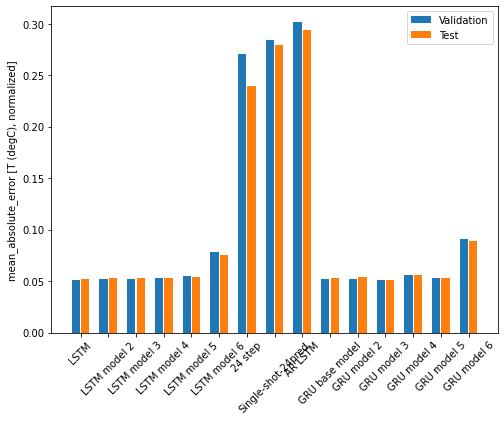

In [135]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = modelGRU1.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [136]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750
24 step     : 0.2398
Single-shot-24pred: 0.2795
AR LSTM     : 0.2937
GRU base model: 0.0534
GRU model 2 : 0.0538
GRU model 3 : 0.0514
GRU model 4 : 0.0563
GRU model 5 : 0.0532
GRU model 6 : 0.0887


Best perfomance model


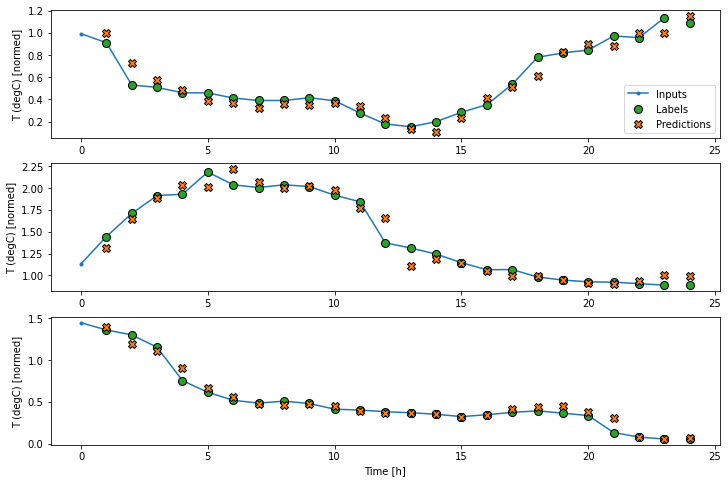

In [137]:
# Plot evaluation of the model with best performance score
print('Best perfomance model')
wide_window.plot(modelGRU3)

###### Analysis

Looking at the performance the GRU models are very similar to the LSTM models. Only model 6 with 2 layer including in-layer dropouts performe worse.<br>
The 3ed GRU model perfroms best, and also beats the best LSTM model (model 1).<br>
<br>
The GRU units have a more simple construction than the LSTM untis. As the GRU models perform as well, it is usually better to use the GRU model. Comparing time it took to run the test, it was almost the same, but om larger datasets the GRU models could outperform the LSTM comparing runtime.<br>
<br>
The best GRU model (and LSTM) in this test was GRU model 3, which ran different activation functions than the other models. Looking at the graph above, it looks really good forcasting the temperature, but as in the LSTM model it has problem when the temperature fluctuates more.

#### Model B1 - One step 24 hours forwards

In [138]:
units = 32

modelGRUC1 = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units, 
        return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [139]:
start_time = time.time()

historyGRUC1 = compile_and_fit(modelGRUC1, tewntyfour_step_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/20
1533/1533 - 2s - loss: 0.1299 - mean_absolute_error: 0.2780 - val_loss: 0.1197 - val_mean_absolute_error: 0.2697
Epoch 2/20
1533/1533 - 2s - loss: 0.1163 - mean_absolute_error: 0.2657 - val_loss: 0.1196 - val_mean_absolute_error: 0.2698
Epoch 3/20
1533/1533 - 2s - loss: 0.1150 - mean_absolute_error: 0.2642 - val_loss: 0.1197 - val_mean_absolute_error: 0.2699
Epoch 4/20
1533/1533 - 2s - loss: 0.1144 - mean_absolute_error: 0.2637 - val_loss: 0.1196 - val_mean_absolute_error: 0.2698
Epoch 5/20
1533/1533 - 2s - loss: 0.1136 - mean_absolute_error: 0.2627 - val_loss: 0.1190 - val_mean_absolute_error: 0.2693
Epoch 6/20
1533/1533 - 2s - loss: 0.1129 - mean_absolute_error: 0.2619 - val_loss: 0.1183 - val_mean_absolute_error: 0.2683
Epoch 7/20
1533/1533 - 2s - loss: 0.1123 - mean_absolute_error: 0.2613 - val_loss: 0.1189 - val_mean_absolute_error: 0.2688
Epoch 8/20
1533/1533 - 2s - loss: 0.1117 - mean_absolute_error: 0.2605 - val_loss: 0.1194 - val_mean_absolute_error: 0.2694
Elapsed 

24 step


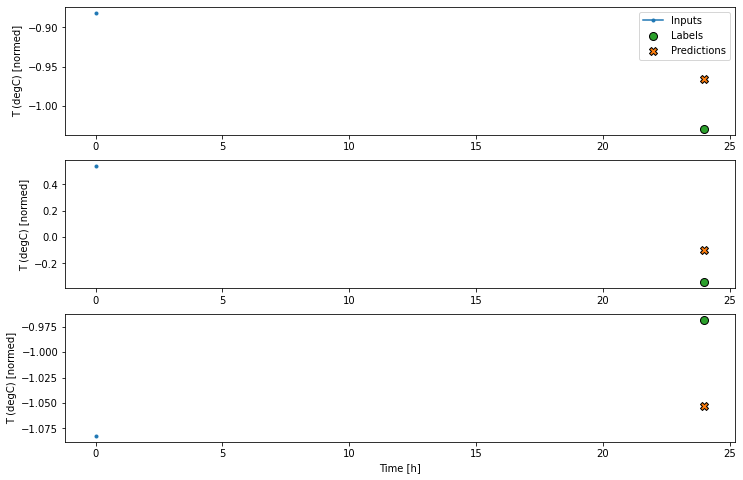

In [140]:
print('24 step')
tewntyfour_step_window.plot(modelGRUC1)

In [141]:
IPython.display.clear_output()
val_performance['GRU 24 step'] = modelGRUC1.evaluate(tewntyfour_step_window.val)
performance['GRU 24 step'] = modelGRUC1.evaluate(tewntyfour_step_window.test, verbose=0)



438/438 [==============================] - ETA: 0s - loss: 0.1389 - mean_absolute_error: 0.303 - ETA: 0s - loss: 0.1120 - mean_absolute_error: 0.259 - ETA: 0s - loss: 0.1188 - mean_absolute_error: 0.269 - ETA: 0s - loss: 0.1196 - mean_absolute_error: 0.270 - ETA: 0s - loss: 0.1187 - mean_absolute_error: 0.268 - ETA: 0s - loss: 0.1189 - mean_absolute_error: 0.268 - ETA: 0s - loss: 0.1185 - mean_absolute_error: 0.268 - ETA: 0s - loss: 0.1198 - mean_absolute_error: 0.269 - ETA: 0s - loss: 0.1191 - mean_absolute_error: 0.269 - ETA: 0s - loss: 0.1194 - mean_absolute_error: 0.269 - 0s 1ms/step - loss: 0.1194 - mean_absolute_error: 0.2694


In [142]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750
24 step     : 0.2398
Single-shot-24pred: 0.2795
AR LSTM     : 0.2937
GRU base model: 0.0534
GRU model 2 : 0.0538
GRU model 3 : 0.0514
GRU model 4 : 0.0563
GRU model 5 : 0.0532
GRU model 6 : 0.0887
GRU 24 step : 0.2406


###### Comment

We see that the GRU model has the same probelm with predict values further into the future. More analysis further down

#### Model B2 - One-shot for 24 predictions

In [143]:
start_time = time.time()

modelGRUC2 = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

historyGRUC2 = compile_and_fit(modelGRUC2, multi_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/20
1532/1532 - 9s - loss: 0.2801 - mean_absolute_error: 0.3530 - val_loss: 0.2280 - val_mean_absolute_error: 0.3038
Epoch 2/20
1532/1532 - 8s - loss: 0.2186 - mean_absolute_error: 0.2947 - val_loss: 0.2203 - val_mean_absolute_error: 0.2939
Epoch 3/20
1532/1532 - 8s - loss: 0.2110 - mean_absolute_error: 0.2862 - val_loss: 0.2170 - val_mean_absolute_error: 0.2898
Epoch 4/20
1532/1532 - 8s - loss: 0.2073 - mean_absolute_error: 0.2821 - val_loss: 0.2148 - val_mean_absolute_error: 0.2866
Epoch 5/20
1532/1532 - 8s - loss: 0.2047 - mean_absolute_error: 0.2795 - val_loss: 0.2139 - val_mean_absolute_error: 0.2853
Epoch 6/20
1532/1532 - 8s - loss: 0.2026 - mean_absolute_error: 0.2776 - val_loss: 0.2130 - val_mean_absolute_error: 0.2841
Epoch 7/20
1532/1532 - 8s - loss: 0.2010 - mean_absolute_error: 0.2762 - val_loss: 0.2140 - val_mean_absolute_error: 0.2848
Epoch 8/20
1532/1532 - 8s - loss: 0.1996 - mean_absolute_error: 0.2751 - val_loss: 0.2130 - val_mean_absolute_error: 0.2838
Elapsed 

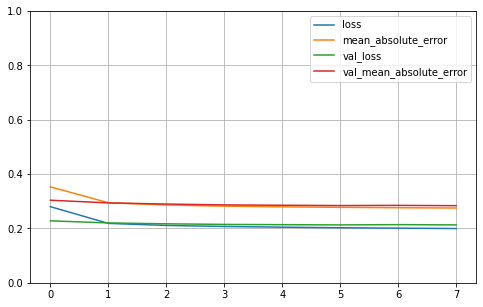

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(historyGRUC2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

437/437 [==============================] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.281 - ETA: 0s - loss: 0.2120 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2109 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.285 - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2125 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2135 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2130 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2123 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2129 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2132 - mean_absolute_error: 0.284 - ETA: 0s - loss: 0.2128 - mean_absolute_error: 0.283 - ETA: 0s - loss: 0.2127 - mean_absolute_error: 0.283 - 1s 2ms/step - loss: 0.2130 - mean_absol

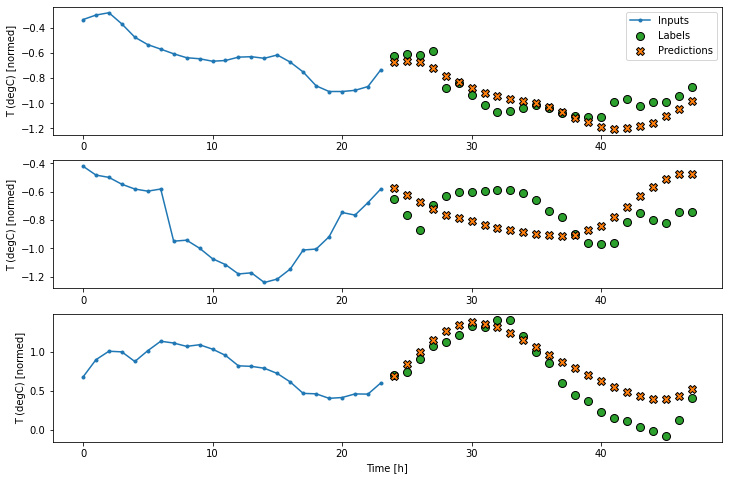

In [145]:
IPython.display.clear_output()

val_performance['GRU Single-shot-24pred'] = modelGRUC2.evaluate(multi_window.val)
performance['GRU Single-shot-24pred'] = modelGRUC2.evaluate(multi_window.test, verbose=0)
multi_window.plot(modelGRUC2)




we go directly to the next model

#### Model B3 - Autoregressive - Predict all 24 forward hours with each prediction going into the next prediction

In [147]:
# We replace LSTMcell with GRUcell

class FeedBackGRU(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.gru_cell = tf.keras.layers.GRUCell(units)
    # Also wrap the GRUCell in an RNN to simplify the `warmup` method.
    self.gru_rnn = tf.keras.layers.RNN(self.gru_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)



In [148]:
modelGRUC3 = FeedBackGRU(units=units, out_steps=OUT_STEPS)

In [149]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.gru_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBackGRU.warmup = warmup

In [150]:
predictionGRU, stateGRU = modelGRUC3.warmup(multi_window.example[0])
predictionGRU.shape


TensorShape([32, 19])

In [151]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictionsGRU = []
  # Initialize the gru state
  predictionGRU, stateGRU = self.warmup(inputs)

  # Insert the first prediction
  predictionsGRU.append(predictionGRU)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = predictionGRU
    # Execute one gru step.
    x, stateGRU = self.gru_cell(x, states=stateGRU,
                              training=training)
    # Convert the gru output to a prediction.
    predictionGRU = self.dense(x)
    # Add the prediction to the output
    predictionsGRU.append(predictionGRU)

  # predictions.shape => (time, batch, features)
  predictionsGRU = tf.stack(predictionsGRU)
  # predictions.shape => (batch, time, features)
  predictionsGRU = tf.transpose(predictionsGRU, [1, 0, 2])
  return predictionsGRU

FeedBackGRU.call = call

In [152]:
print('Output shape (batch, time, features): ', modelGRUC3(multi_window.example[0]).shape)



Output shape (batch, time, features):  (32, 24, 19)


In [153]:
start_time = time.time()

historyGRUC3 = compile_and_fit(modelGRUC3, multi_window)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))



Epoch 1/20
1532/1532 - 12s - loss: 0.3155 - mean_absolute_error: 0.3862 - val_loss: 0.2427 - val_mean_absolute_error: 0.3238
Epoch 2/20
1532/1532 - 11s - loss: 0.2348 - mean_absolute_error: 0.3166 - val_loss: 0.2296 - val_mean_absolute_error: 0.3088
Epoch 3/20
1532/1532 - 11s - loss: 0.2242 - mean_absolute_error: 0.3040 - val_loss: 0.2281 - val_mean_absolute_error: 0.3063
Epoch 4/20
1532/1532 - 11s - loss: 0.2194 - mean_absolute_error: 0.2985 - val_loss: 0.2280 - val_mean_absolute_error: 0.3036
Epoch 5/20
1532/1532 - 11s - loss: 0.2158 - mean_absolute_error: 0.2944 - val_loss: 0.2243 - val_mean_absolute_error: 0.3002
Epoch 6/20
1532/1532 - 11s - loss: 0.2134 - mean_absolute_error: 0.2918 - val_loss: 0.2244 - val_mean_absolute_error: 0.2997
Epoch 7/20
1532/1532 - 11s - loss: 0.2109 - mean_absolute_error: 0.2893 - val_loss: 0.2228 - val_mean_absolute_error: 0.2969
Epoch 8/20
1532/1532 - 12s - loss: 0.2095 - mean_absolute_error: 0.2880 - val_loss: 0.2217 - val_mean_absolute_error: 0.2955


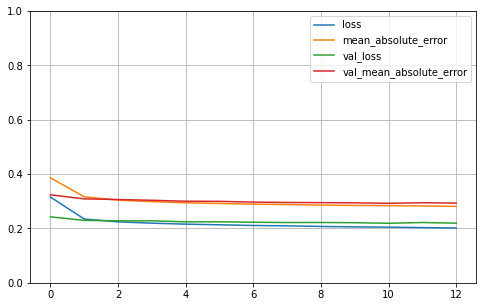

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(historyGRUC3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()



437/437 [==============================] - ETA: 0s - loss: 0.2001 - mean_absolute_error: 0.288 - ETA: 1s - loss: 0.2013 - mean_absolute_error: 0.281 - ETA: 1s - loss: 0.2113 - mean_absolute_error: 0.286 - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.289 - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.290 - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2177 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2156 - mean_absolute_error: 0.290 - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2176 - mean_absolute_error: 0.292 - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.292 - ETA: 0s - loss: 0.2183 - mean_absolute_error: 0.292 - ETA: 0s - loss: 0.2185 - mean_absolute_error: 0.292 - ETA: 0s - loss: 0.2174 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2177 - mean_absolute_error: 0.291 - ETA: 0s - loss: 0.2178 - mean_absolute_

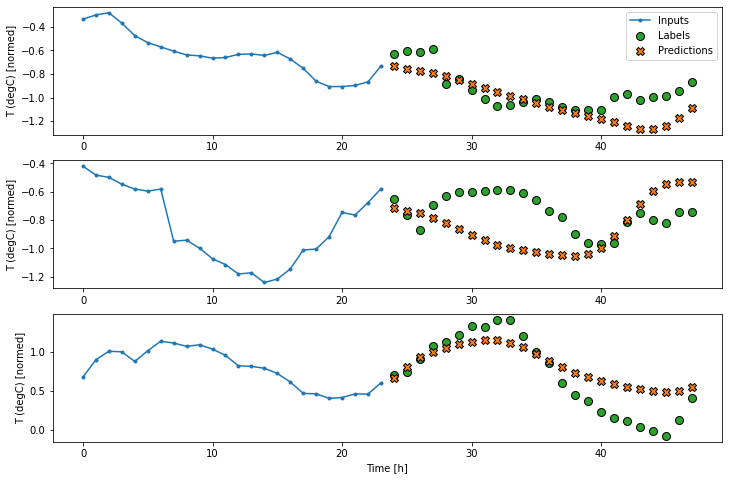

In [155]:
IPython.display.clear_output()

val_performance['GRU AR LSTM'] = modelGRUC3.evaluate(multi_window.val)
performance['GRU AR LSTM'] = modelGRUC3.evaluate(multi_window.test, verbose=0)
multi_window.plot(modelGRUC3)




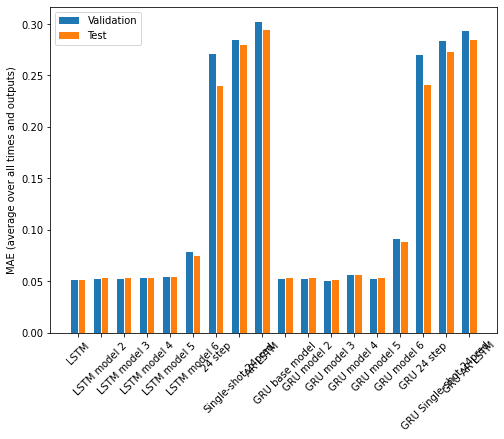

In [156]:
x = np.arange(len(performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = modelGRU1.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


In [157]:
for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')



LSTM    : 0.0518
LSTM model 2: 0.0534
LSTM model 3: 0.0532
LSTM model 4: 0.0533
LSTM model 5: 0.0542
LSTM model 6: 0.0750
24 step : 0.2398
Single-shot-24pred: 0.2795
AR LSTM : 0.2937
GRU base model: 0.0534
GRU model 2: 0.0538
GRU model 3: 0.0514
GRU model 4: 0.0563
GRU model 5: 0.0532
GRU model 6: 0.0887
GRU 24 step: 0.2406
GRU Single-shot-24pred: 0.2732
GRU AR LSTM: 0.2849


#### Analysis

The GRU models predicting all the 24 steps forward perform as well as the LSTM models (slightly better). The prediction of one value 24 steps forward is more or less equivalent to the LSTM model. The execution times between the GRU and LSTM is quite close. <br>
<br>
The best model for predicting one step ahead (forward) was a GRU model. The best for predicting 24 steps forward was also a GRU model. 
<br>
<br>
It is more difficult to predict several steps into the future for the models and hyperparameter tuning can make a difference, but several have in this task quit similar predictions.

##### Copyright

This file is based on a tutorial (link in the top of the file), with the following Apache License

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.